# Demand Prediction
### Resources: 
- **Prohet**: 
    - https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/
    - https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors
    - https://facebook.github.io/prophet/docs/quick_start.html
- **Recursive autoregressive forecast**:
    - https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html
- **Neural Prophet**: 
    - https://www.kaggle.com/code/ohseokkim/predicting-future-by-lstm-prophet-neural-prophet
    - https://bobrupakroy.medium.com/neural-prophet-for-time-series-27bfeeaa5c7d

### Import libraries

In [30]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timedelta, date

# Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_plotly, plot_components_plotly,plot_forecast_component, plot_yearly
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

# Neural Prophet
from neuralprophet import NeuralProphet

# Recursive autoregressive forecasting
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.ensemble import RandomForestRegressor
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

ModuleNotFoundError: No module named 'skforecast'

### Import data

In [34]:
itinerarios = pd.read_parquet('../Data/Itinerarios/itinerarios_bases3.parquet')

# No incluimos en el modelo de predicción los movimientos realizados por empleados de bicimad (user_type==3)
itinerarios1 = itinerarios[itinerarios["user_type"]!= 3]
# Solo incluimos en el modelo aquellos movimientos que duran más de 5 minutos (no se ha cogido una bici defectuosa) y menos de 1 dia (no se ha perdido)
itinerarios1 = itinerarios1[itinerarios1["status"] == "short_rental"]

# Contamos demanda por hora y día
itinerarios2 = itinerarios1[["unplug_hourTime"]]
itinerarios3 = itinerarios2.groupby("unplug_hourTime").size().reset_index(name='Count')
itinerarios3["unplug_hourTime"] = pd.to_datetime(itinerarios3["unplug_hourTime"])
itinerarios3["unplug_hourTime"] = itinerarios3["unplug_hourTime"].dt.tz_localize(None)
itinerarios4 = itinerarios3[itinerarios3["unplug_hourTime"] >= pd.to_datetime('20190801')]
itinerarios4.columns = ['ds', 'y']

itinerarios4.head()

,ds,y
259,2019-08-01 00:00:00,136
260,2019-08-01 01:00:00,74
261,2019-08-01 02:00:00,66
262,2019-08-01 03:00:00,52
263,2019-08-01 04:00:00,100


Definir variables temporales

In [35]:
def itsFriday(df):
    """
    Parametros:
    df: pd.DataFrame: Dataframe que contiene la serie temporal en formato prophet
    Salida:
    df +variable adicional que indica si es viernes
    """
    df["friday"] = df["ds"].map(lambda x: 1 if x.isoweekday() == 5 else 0)
    return df 

def itsWeekend(df):
    """
    Parametros:
    df: pd.DataFrame: Serie temporal en formato prophet
    Salida:
    df + variable  que indica si es fin de semana
    """
    df["is_weekend"] = df["ds"].map(lambda x: 1 if x.isoweekday() in [6,7] else 0)
    return df 

def itsWorkday(df):
    """
    Parametros:
    df: pd.DataFrame: Serie temporal en formato prophet
    Salida:
    df + variable  que indica si es día laborable
    """
    df["workday"] = df["ds"].map(lambda x: 1 if x.isoweekday() not in [5,6,7] else 0)
    return df 

def entryWork(df,holidays):
    """
    Parametros:
    df: pd.DataFrame:Serie temporal en formato prophet
    holidays: pd.DataFrame. Vacaciones en formato Prophet
    Salida:
    Se construye una variable adicional que indica si es hora de entrada al trabajo
    """
    df["entryWork"] = df["ds"].map(lambda x: 1 if (x.isoweekday() not in [6,7]) & (x.hour in [6,7,8]) else 0)
    df["entryWork"] = np.where(df["ds"].map(lambda x: datetime(x.year,x.month,x.day)).isin(holidays["ds"]),0,df["entryWork"])
    
    return df

Definition of holidays

In [42]:
# De cara a un futuro habría que añadir fiestas futuras
fiestas_madrid = pd.DataFrame({
  'holiday': 'fiestas',
  'ds': pd.to_datetime(['2019-01-01', '2019-01-07', '2019-04-18',
                        '2019-04-19', '2019-05-01', '2019-05-02',
                        '2019-05-15', '2019-08-15', '2019-10-12',
                        '2019-11-01', '2019-11-09', '2019-12-06',
                        '2019-12-09', '2019-12-25', '2020-01-01', '2020-01-06', '2020-04-09',
                        '2020-04-10', '2020-05-01', '2020-05-02',
                        '2020-05-15', '2020-08-15', '2020-10-12',
                        '2020-11-02', '2020-11-09', '2020-12-07',
                        '2020-12-08', '2020-12-25']),
  'lower_window': -1,
  'upper_window': 0,
})

navidades = pd.DataFrame({
  'holiday': 'navidades',
  'ds': pd.date_range(start='2018-12-24', end='2019-01-06').append(pd.date_range(start='2019-08-01', end='2019-08-31')),
  'lower_window': 0,
  'upper_window': 0,
})

verano = pd.DataFrame({
  'holiday': 'verano',
  'ds': pd.date_range(start='2019-12-24', end='2020-01-06').append(pd.date_range(start='2020-08-01', end='2020-08-31')),
  'lower_window': 0,
  'upper_window': 0,
})
holidays = pd.concat((fiestas_madrid, navidades, verano))

**SPLIT IN TRAIN AND TEST**
- Train: 01/08/2029 - 11/12/2019
- Test: 12/12/2019 - 2016/12/2019

In [189]:
train = itinerarios4[itinerarios4["ds"]<pd.to_datetime("20191212")] 
test = itinerarios4[(itinerarios4["ds"]>=pd.to_datetime("20191212")) & (itinerarios4["ds"]<pd.to_datetime("20191216"))] 

Apply temporal regressors

In [190]:
train = itsFriday(train)
train = itsWeekend(train)
train = itsWorkday(train)
train = entryWork(train,holidays)

WARNING - (py.warnings._showwarnmsg) - C:\Users\Marta\AppData\Local\Temp\ipykernel_1236\3347733711.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


WARNING - (py.warnings._showwarnmsg) - C:\Users\Marta\AppData\Local\Temp\ipykernel_1236\3347733711.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


WARNING - (py.warnings._showwarnmsg) - C:\Users\Marta\AppData\Local\Temp\ipykernel_1236\3347733711.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

### Neutralize data to reduce variability!!!

In [191]:
train_log = train.copy()
train_log["y"] = np.log(train_log["y"])

In [48]:
train_log.head()

,ds,y,friday,is_weekend,workday,entryWork
259,2019-08-01 00:00:00,4.912655,0,0,1,0
260,2019-08-01 01:00:00,4.304065,0,0,1,0
261,2019-08-01 02:00:00,4.189655,0,0,1,0
262,2019-08-01 03:00:00,3.951244,0,0,1,0
263,2019-08-01 04:00:00,4.605170,0,0,1,0


# Prophet

### Prophet sin tunear

The result of the predict() function is a DataFrame that contains many columns. Perhaps the most important columns are the forecast date time (‘ds‘), the forecasted value (‘yhat‘), and the lower and upper bounds on the predicted value (‘yhat_lower‘ and ‘yhat_upper‘) that provide uncertainty of the forecast.

In [ ]:
# Creación del modelo
model = Prophet()
model.fit(train_log)

# use the model to make a forecast
forecast = model.predict(test)

# calculate MAE between expected and predicted values for december
y_true = test['y'].values
y_pred = forecast['yhat'].values

# We convert the negative values of y_pred to 0 as demand cannot be negative
mse = mean_squared_error(y_true, y_pred)
print('MSE without deleting negative values: %.3f' % mse)
mae = mean_absolute_error(y_true, y_pred)
print('MAE without deleting negative values:: %.3f' % mae)

# plot expected vs actual
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

### **Forecast Model Tuning with Additional Regressors in Prophet**  
Add regressors to Prophet model to improve forecast accuracy
1. Including holidays in the model: If you have holidays or other recurring events that you’d like to model, you must create a dataframe for them. It has two columns (holiday and ds) and a row for each occurrence of the holiday. 
2. Seasonalities are estimated using a partial Fourier sum. The number of terms in the partial sum (the order) is a parameter that determines how quickly the seasonality can change. To illustrate this, consider the Peyton Manning data from the Quickstart. The default Fourier order for yearly seasonality is 10, which produces this fit:

### Hyperparameter tuning

In [49]:
space = {
    "n_changepoints": hp.quniform("n_changepoints",40,100,1),
    "changepoint_range": hp.uniform("changepoint_range",0.7,0.9),
    "fourier_weekly": hp.quniform("fourier_weekly",7,9,1),
    "fourier_daily": hp.quniform("fourier_daily",12,15,1),
    "seasonality_prior_scale": hp.uniform("seasonality_prior_scale",0,6),
    "holidays_prior_scale": hp.uniform("holidays_prior_scale", 0,6),
    "changepoint_prior_scale": hp.uniform("changepoint_prior_scale",7,10),
}

def metrics_report(df):
    """
    Parametros:
    df: pd.DataFrame. Datos reales + predicciones de la serie temporal
    Output:
    Un objeto serie que contiene las metricas que vamos a calcular
    """
    
    rmse = np.sqrt(mean_squared_error(df["y"],df["yhat"]))
    mae = mean_absolute_error(df["y"],df["yhat"])
    mape = 100*mean_absolute_percentage_error(df["y"],df["yhat"])
    
    return pd.Series(dict(RMSE = rmse, MAE = mae, MAPE = mape))

def tuning_prophet(params):
    model = Prophet(holidays = fiestas_madrid,
                    n_changepoints = int(params["n_changepoints"]),
                    changepoint_range = params["changepoint_range"],
                    seasonality_prior_scale = params["seasonality_prior_scale"],
                    holidays_prior_scale = params["holidays_prior_scale"],
                    changepoint_prior_scale = params["changepoint_prior_scale"],
                    weekly_seasonality = False,
                    daily_seasonality = False,
                    yearly_seasonality = False,
                   )
    
    # Monto los regresores
    model.add_regressor("friday")
    model.add_regressor("is_weekend")
    model.add_regressor("workday")
    model.add_regressor("entryWork")
    
    # Monto las estacionalidades
    model.add_seasonality("daily", fourier_order = int(params["fourier_daily"]), period = 1)
    model.add_seasonality("weekly", fourier_order = int(params["fourier_weekly"]), period = 7)
    
    model.fit(train_log)
    
    cutoffs = [datetime(2019,12,11,23,0,0) - timedelta(days = 4*x) for x in [3,2,1]]
    
    df_cv = cross_validation(model, cutoffs = cutoffs, horizon = '96 hours', parallel = "processes")
    df_cv["y"] = np.exp(df_cv["y"])
    df_cv["yhat"] = np.exp(df_cv["yhat"])
    df_cv["cutoff"] = df_cv["cutoff"].astype(str)
    
    cv_metrics = df_cv.groupby("cutoff").apply(metrics_report)
    print(cv_metrics)
    final_metric = np.mean(cv_metrics["RMSE"])
    print("La métrica final de este modelo es: {}".format(round(final_metric,4)))
    print("\n")
    
    return {"loss": final_metric, "status": STATUS_OK, "model": model}

In [50]:
trials = Trials()
best = fmin(tuning_prophet,space,algo=tpe.suggest,max_evals = 25,trials = trials)

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

14:24:13 - cmdstanpy - INFO - Chain [1] start processing

14:24:21 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE
cutoff                                                
2019-11-29 23:00:00  151.528146  120.922218  98.370867
2019-12-03 23:00:00  105.117203   74.435874  34.221999
2019-12-07 23:00:00  116.776474   81.072051  38.184713
La métrica final de este modelo es: 124.4739          
  4%|▍         | 1/25 [00:34<13:59, 34.99s/trial, best loss: 124.4739408535799]

14:24:48 - cmdstanpy - INFO - Chain [1] start processing

14:25:07 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                         
cutoff                                                
2019-11-29 23:00:00  156.810938  123.819228  95.795080
2019-12-03 23:00:00  110.665706   81.070187  34.529300
2019-12-07 23:00:00  113.336709   80.986222  39.041735
La métrica final de este modelo es: 126.9378                                   
  8%|▊         | 2/25 [01:47<21:47, 56.83s/trial, best loss: 124.4739408535799]

14:26:00 - cmdstanpy - INFO - Chain [1] start processing

14:26:09 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                         
cutoff                                                
2019-11-29 23:00:00  160.084628  126.473480  94.673130
2019-12-03 23:00:00  106.661124   78.832623  34.800699
2019-12-07 23:00:00  113.911587   82.062797  39.698018
La métrica final de este modelo es: 126.8858                                   
 12%|█▏        | 3/25 [02:26<17:55, 48.90s/trial, best loss: 124.4739408535799]

14:26:40 - cmdstanpy - INFO - Chain [1] start processing

14:26:56 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE        MAPE                        
cutoff                                                 
2019-11-29 23:00:00  153.062349  121.082527  100.058476
2019-12-03 23:00:00  116.101947   83.730728   34.783585
2019-12-07 23:00:00  104.644336   76.711854   39.657639
La métrica final de este modelo es: 124.6029                                   
 16%|█▌        | 4/25 [03:37<20:09, 57.62s/trial, best loss: 124.4739408535799]

14:27:51 - cmdstanpy - INFO - Chain [1] start processing

14:28:11 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE        MAPE                        
cutoff                                                 
2019-11-29 23:00:00  158.038434  125.234826  108.693825
2019-12-03 23:00:00  112.132291   79.967671   36.590988
2019-12-07 23:00:00  121.568160   83.726851   36.279509
La métrica final de este modelo es: 130.5796                                   
 20%|██        | 5/25 [04:50<21:02, 63.14s/trial, best loss: 124.4739408535799]

14:29:04 - cmdstanpy - INFO - Chain [1] start processing

14:29:08 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                         
cutoff                                                
2019-11-29 23:00:00  154.485548  121.920295  95.269771
2019-12-03 23:00:00  112.283741   81.263307  34.618585
2019-12-07 23:00:00  108.455082   78.045458  39.368345
La métrica final de este modelo es: 125.0748                                   
 24%|██▍       | 6/25 [05:25<16:58, 53.63s/trial, best loss: 124.4739408535799]

14:29:39 - cmdstanpy - INFO - Chain [1] start processing

14:29:45 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                         
cutoff                                                
2019-11-29 23:00:00  155.246438  122.596465  93.717515
2019-12-03 23:00:00  111.120057   81.525081  34.237254
2019-12-07 23:00:00  110.677098   79.012412  38.608099
La métrica final de este modelo es: 125.6812                                   
 28%|██▊       | 7/25 [06:04<14:38, 48.83s/trial, best loss: 124.4739408535799]

14:30:18 - cmdstanpy - INFO - Chain [1] start processing

14:30:37 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                         
cutoff                                                
2019-11-29 23:00:00  158.219720  125.492102  92.548857
2019-12-03 23:00:00  112.019765   81.523060  33.058762
2019-12-07 23:00:00  106.987933   76.997299  39.452029
La métrica final de este modelo es: 125.7425                                   
 32%|███▏      | 8/25 [07:16<15:57, 56.30s/trial, best loss: 124.4739408535799]

14:31:30 - cmdstanpy - INFO - Chain [1] start processing

14:31:37 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                         
cutoff                                                
2019-11-29 23:00:00  163.333188  127.691070  87.595777
2019-12-03 23:00:00  105.350602   77.192937  32.443973
2019-12-07 23:00:00  113.107403   80.696573  39.899621
La métrica final de este modelo es: 127.2637                                   
 36%|███▌      | 9/25 [08:01<14:00, 52.50s/trial, best loss: 124.4739408535799]

14:32:14 - cmdstanpy - INFO - Chain [1] start processing

14:32:36 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                         
cutoff                                                
2019-11-29 23:00:00  158.949995  125.730951  90.610021
2019-12-03 23:00:00  105.918051   77.070397  32.898751
2019-12-07 23:00:00  112.469246   80.618029  40.181769
La métrica final de este modelo es: 125.7791                                   
 40%|████      | 10/25 [09:16<14:51, 59.45s/trial, best loss: 124.4739408535799]

14:33:29 - cmdstanpy - INFO - Chain [1] start processing

14:33:40 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                          
cutoff                                                
2019-11-29 23:00:00  157.361932  124.401721  91.088199
2019-12-03 23:00:00  110.616761   81.371087  34.693204
2019-12-07 23:00:00  112.807172   80.539319  38.951761
La métrica final de este modelo es: 126.9286                                    
 44%|████▍     | 11/25 [10:16<13:56, 59.76s/trial, best loss: 124.4739408535799]

14:34:30 - cmdstanpy - INFO - Chain [1] start processing

14:34:50 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                          
cutoff                                                
2019-11-29 23:00:00  160.227653  126.595348  91.444403
2019-12-03 23:00:00  109.850433   80.722369  34.287084
2019-12-07 23:00:00  112.466692   80.197878  38.896298
La métrica final de este modelo es: 127.5149                                    
 48%|████▊     | 12/25 [11:31<13:55, 64.30s/trial, best loss: 124.4739408535799]

14:35:44 - cmdstanpy - INFO - Chain [1] start processing

14:35:52 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                          
cutoff                                                
2019-11-29 23:00:00  151.448834  121.135577  98.635406
2019-12-03 23:00:00  104.002577   74.255797  33.616359
2019-12-07 23:00:00  105.103719   77.933834  42.000361
La métrica final de este modelo es: 120.185                                     
 52%|█████▏    | 13/25 [12:10<11:19, 56.63s/trial, best loss: 120.18504322102082]

14:36:23 - cmdstanpy - INFO - Chain [1] start processing

14:36:41 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                           
cutoff                                                
2019-11-29 23:00:00  156.601276  123.768527  94.462312
2019-12-03 23:00:00  113.934718   83.615601  34.474305
2019-12-07 23:00:00  108.718729   77.504910  38.332692
La métrica final de este modelo es: 126.4182                                     
 56%|█████▌    | 14/25 [13:18<11:00, 60.04s/trial, best loss: 120.18504322102082]

14:37:31 - cmdstanpy - INFO - Chain [1] start processing

14:37:45 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                           
cutoff                                                
2019-11-29 23:00:00  156.463861  123.665699  93.926169
2019-12-03 23:00:00  117.757335   85.737760  34.718853
2019-12-07 23:00:00  108.361765   77.213835  38.281253
La métrica final de este modelo es: 127.5277                                     
 60%|██████    | 15/25 [14:32<10:42, 64.30s/trial, best loss: 120.18504322102082]

14:38:45 - cmdstanpy - INFO - Chain [1] start processing

14:38:51 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                           
cutoff                                                
2019-11-29 23:00:00  155.225319  122.377251  96.773501
2019-12-03 23:00:00  112.347840   80.844310  34.990528
2019-12-07 23:00:00  109.228678   77.947615  38.786332
La métrica final de este modelo es: 125.6006                                     
 64%|██████▍   | 16/25 [15:08<08:21, 55.72s/trial, best loss: 120.18504322102082]

14:39:21 - cmdstanpy - INFO - Chain [1] start processing

14:39:36 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                           
cutoff                                                
2019-11-29 23:00:00  160.268892  126.490297  97.723717
2019-12-03 23:00:00  109.284463   80.364528  34.779047
2019-12-07 23:00:00  114.125837   81.808779  39.174268
La métrica final de este modelo es: 127.8931                                     
 68%|██████▊   | 17/25 [16:12<07:47, 58.47s/trial, best loss: 120.18504322102082]

14:40:26 - cmdstanpy - INFO - Chain [1] start processing

14:40:40 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                           
cutoff                                                
2019-11-29 23:00:00  159.330659  125.799784  97.178536
2019-12-03 23:00:00  110.186054   80.204444  34.737375
2019-12-07 23:00:00  109.975350   78.771110  38.975235
La métrica final de este modelo es: 126.4974                                     
 72%|███████▏  | 18/25 [17:12<06:51, 58.81s/trial, best loss: 120.18504322102082]

14:41:26 - cmdstanpy - INFO - Chain [1] start processing

14:41:34 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                           
cutoff                                                
2019-11-29 23:00:00  158.977938  125.697077  91.977422
2019-12-03 23:00:00  109.201606   80.536626  34.585917
2019-12-07 23:00:00  112.775577   80.410118  38.885472
La métrica final de este modelo es: 126.985                                      
 76%|███████▌  | 19/25 [17:56<05:26, 54.47s/trial, best loss: 120.18504322102082]

14:42:10 - cmdstanpy - INFO - Chain [1] start processing

14:42:27 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE        MAPE                          
cutoff                                                 
2019-11-29 23:00:00  153.738960  121.663342  102.031945
2019-12-03 23:00:00  114.631417   82.632229   34.807222
2019-12-07 23:00:00  103.774107   75.911706   39.121614
La métrica final de este modelo es: 124.0482                                     
 80%|████████  | 20/25 [19:06<04:54, 58.88s/trial, best loss: 120.18504322102082]

14:43:19 - cmdstanpy - INFO - Chain [1] start processing

14:43:31 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE        MAPE                          
cutoff                                                 
2019-11-29 23:00:00  154.189881  123.374518  100.513895
2019-12-03 23:00:00  107.695904   77.161667   33.457752
2019-12-07 23:00:00   99.942347   74.100834   40.818526
La métrica final de este modelo es: 120.6094                                     
 84%|████████▍ | 21/25 [20:02<03:52, 58.19s/trial, best loss: 120.18504322102082]

14:44:16 - cmdstanpy - INFO - Chain [1] start processing

14:44:29 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE        MAPE                          
cutoff                                                 
2019-11-29 23:00:00  153.316632  122.714249  100.916641
2019-12-03 23:00:00  110.144983   78.089920   34.173064
2019-12-07 23:00:00  102.303727   75.121770   40.373511
La métrica final de este modelo es: 121.9218                                     
 88%|████████▊ | 22/25 [20:57<02:51, 57.07s/trial, best loss: 120.18504322102082]

14:45:10 - cmdstanpy - INFO - Chain [1] start processing

14:45:22 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE        MAPE                          
cutoff                                                 
2019-11-29 23:00:00  158.036706  128.186419  114.896070
2019-12-03 23:00:00  106.269120   74.790979   34.295022
2019-12-07 23:00:00  122.585641   83.631034   36.787585
La métrica final de este modelo es: 128.9638                                     
 92%|█████████▏| 23/25 [21:54<01:54, 57.24s/trial, best loss: 120.18504322102082]

14:46:08 - cmdstanpy - INFO - Chain [1] start processing

14:46:22 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                           
cutoff                                                
2019-11-29 23:00:00  153.019605  122.234612  99.125429
2019-12-03 23:00:00  107.342843   76.453578  33.705927
2019-12-07 23:00:00  101.346128   74.789372  40.730556
La métrica final de este modelo es: 120.5695                                     
 96%|█████████▌| 24/25 [22:48<00:56, 56.29s/trial, best loss: 120.18504322102082]

14:47:02 - cmdstanpy - INFO - Chain [1] start processing

14:47:14 - cmdstanpy - INFO - Chain [1] done processing



                           RMSE         MAE       MAPE                           
cutoff                                                
2019-11-29 23:00:00  154.345375  123.013383  95.831326
2019-12-03 23:00:00  106.203162   76.329546  33.020994
2019-12-07 23:00:00  102.065021   75.167126  40.413399
La métrica final de este modelo es: 120.8712                                     
100%|██████████| 25/25 [23:34<00:00, 56.59s/trial, best loss: 120.18504322102082]


In [51]:
results = pd.DataFrame(columns = ["n_changepoints","changepoint_range","fourier_weekly","fourier_daily","seasonality_prior_scale","holidays_prior_scale","changepoint_prior_scale","RMSE"])

models = []
for trial in trials:
    results = results.append(pd.Series(
            {
             "n_changepoints": trial["result"]["model"].n_changepoints,
             "changepoint_range": trial["result"]["model"].changepoint_range,
             "fourier_weekly": trial["misc"]["vals"]["fourier_weekly"][0],
             "fourier_daily": trial["misc"]["vals"]["fourier_daily"][0],
             "seasonality_prior_scale": trial["result"]["model"].seasonality_prior_scale,
             "holidays_prior_scale": trial["result"]["model"].holidays_prior_scale,
             "changepoint_prior_scale": trial["result"]["model"].changepoint_prior_scale,
             "RMSE": trial["result"]["loss"]
            }
        ),
        ignore_index = True
    )
    models.append(trial["result"]["model"])
    
results.sort_values("RMSE",ascending = True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\Marta\AppData\Local\Temp\ipykernel_1236\212835425.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.Series(

WARNING - (py.warnings._showwarnmsg) - C:\Users\Marta\AppData\Local\Temp\ipykernel_1236\212835425.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.Series(

WARNING - (py.warnings._showwarnmsg) - C:\Users\Marta\AppData\Local\Temp\ipykernel_1236\212835425.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.Series(

WARNING - (py.warnings._showwarnmsg) - C:\Users\Marta\AppData\Local\Temp\ipykernel_1236\212835425.py:5: FutureWarning: The frame.append method is deprecated and will be rem

,n_changepoints,changepoint_range,fourier_weekly,fourier_daily,seasonality_prior_scale,holidays_prior_scale,changepoint_prior_scale,RMSE
12,45.0,0.874374,7.0,14.0,4.910636,5.688785,7.724525,120.185043
23,67.0,0.871900,7.0,15.0,5.157128,0.335297,7.681958,120.569525
20,76.0,0.866914,7.0,15.0,5.803938,1.413759,8.374423,120.609377
24,58.0,0.845130,7.0,15.0,4.942041,0.211094,7.747319,120.871186
21,75.0,0.874379,7.0,15.0,5.888257,1.161618,8.434760,121.921781
19,85.0,0.860219,8.0,12.0,5.357368,2.150053,8.705891,124.048161
0,41.0,0.888886,7.0,12.0,3.856928,2.263037,7.598717,124.473941
3,95.0,0.855843,8.0,15.0,2.606903,5.541772,7.310144,124.602878
5,46.0,0.840495,8.0,12.0,1.743487,2.936365,7.502918,125.074791
15,45.0,0.831940,8.0,13.0,4.323634,3.507559,9.129984,125.600612


#### **MODEL WITH LOWEST RMSE (120)**
    n_changepoints	changepoint_range	fourier_weekly	fourier_daily	seasonality_prior_scale	  holidays_prior_scale	changepoint_prior_scale	     RMSE
        45.0	      0.874374	       7.0	          14.0	               4.910636	        5.688785	                7.724525	  120.185043

In [52]:
model = models[12]

In [62]:
forecast = model.make_future_dataframe(periods = 24*4, freq = "H")
forecast = itsFriday(forecast)
forecast = itsWeekend(forecast)
forecast = itsWorkday(forecast)
forecast = entryWork(forecast,holidays)

forecast = model.predict(forecast)
forecast["yhat"] = np.exp(forecast["yhat"])

In [63]:
y_true = test['y'].values
y_pred = forecast['yhat'].iloc[-96:].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('RMSE: %.3f' % rmse)
mse = mean_squared_error(y_true, y_pred)
print('MSE: %.3f' % mse)
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

RMSE: 123.493
MSE: 15250.620
MAE: 93.341


In [69]:
data = [
    go.Scatter(
        x = train["ds"],
        y = train["y"],
        name = "Valores Reales",
        mode = "lines",
    ),
    go.Scatter(
        x = forecast["ds"].iloc[:-96],
        y = forecast["yhat"].iloc[:-96],
        name = "Valores Predichos",
        mode = "lines",
    ),
]

layout = go.Layout(title = "Train. Forecast vs Valores reales", xaxis_title = "Fecha", yaxis_title = "Demanda")

fig = go.Figure(data = data, layout = layout)

fig.show()

In [68]:
data = [
    go.Scatter(
        x = test["ds"],
        y = test["y"],
        name = "Valores Reales",
        mode = "lines",
    ),
    go.Scatter(
        x = forecast["ds"].iloc[-96:],
        y = forecast["yhat"].iloc[-96:],
        name = "Valores Predichos",
        mode = "lines",
    ),
]

layout = go.Layout(title = "Test. Forecast vs Valores reales", xaxis_title = "Fecha", yaxis_title = "Demanda")

fig = go.Figure(data = data, layout = layout)

fig.show()

In [70]:
import pickle
pickle.dump(model, open('predictionProphet.pkl', 'wb'))

### Neural Prophet

In [197]:
mNeural = NeuralProphet(n_changepoints=100, trend_reg=0.05, yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True)
# Monto Eventos
#mNeural.add_events(holidays)
#Monto los regresores
mNeural.add_future_regressor("friday")
mNeural.add_future_regressor("is_weekend")
mNeural.add_future_regressor("workday")
mNeural.add_future_regressor("entryWork")
metricsNeural = mNeural.fit(train_log, freq="H")
forecastNeural = mNeural.predict(train_log)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.937% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 139


  0%|          | 0/137 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.05E-01, min: 1.07E-02


  0%|          | 0/137 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.03E+00, min: 1.07E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.22E-01
Epoch[139/139]: 100%|██████████| 139/139 [00:33<00:00,  4.14it/s, SmoothL1Loss=0.00594, MAE=0.368, RMSE=0.493, Loss=0.00607, RegLoss=0.00158] 
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.937% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.937% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.937% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.937% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


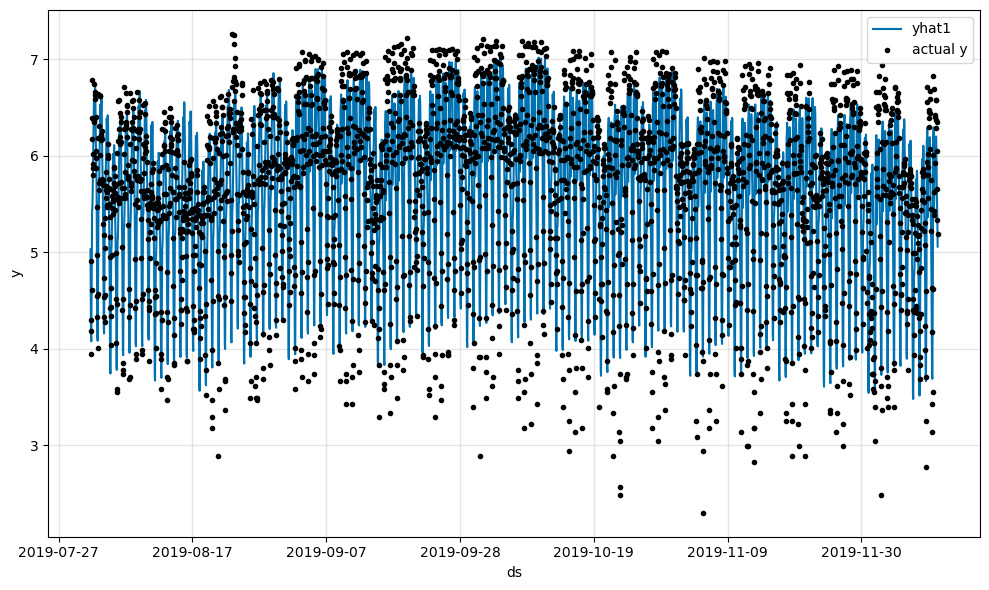

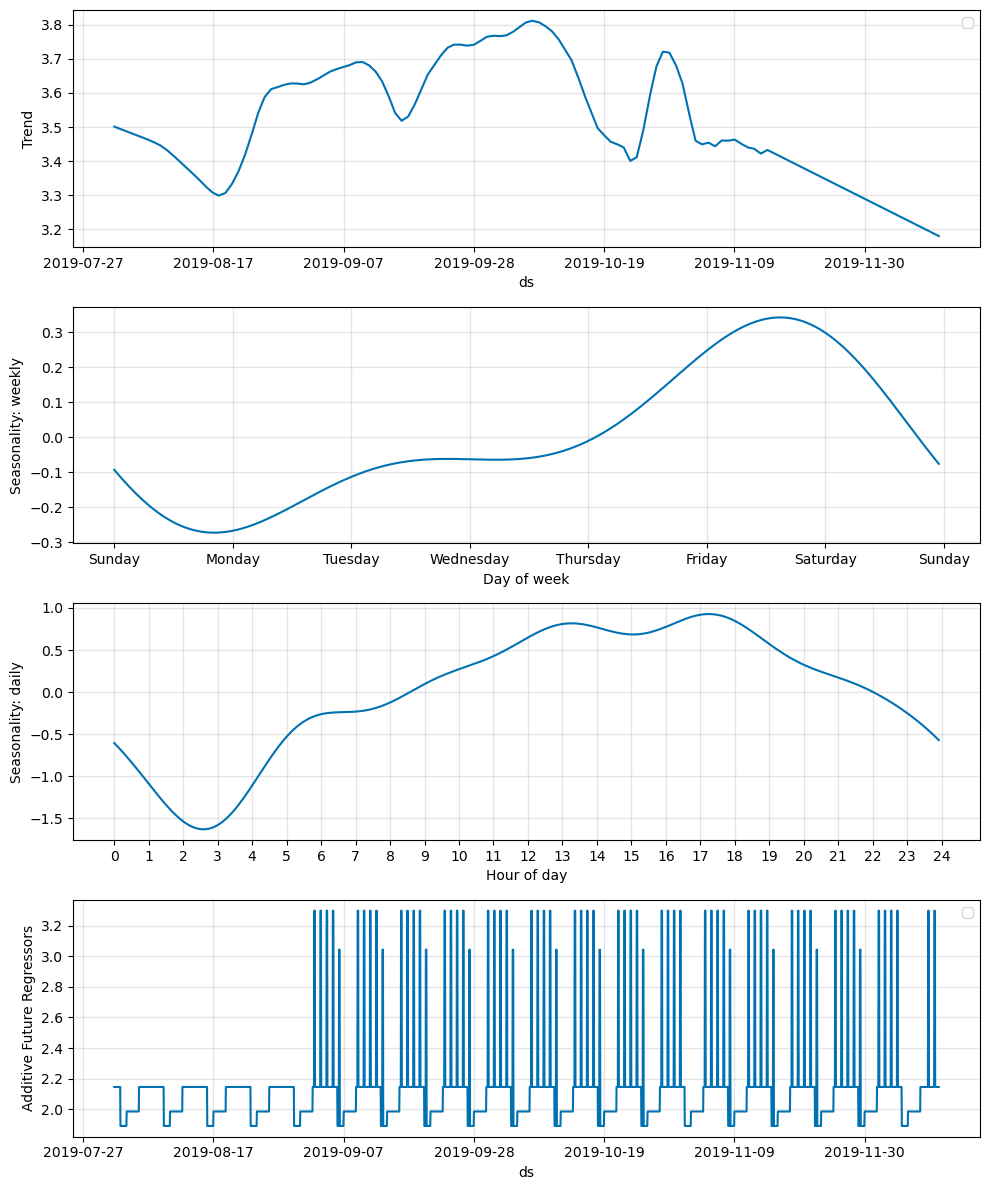

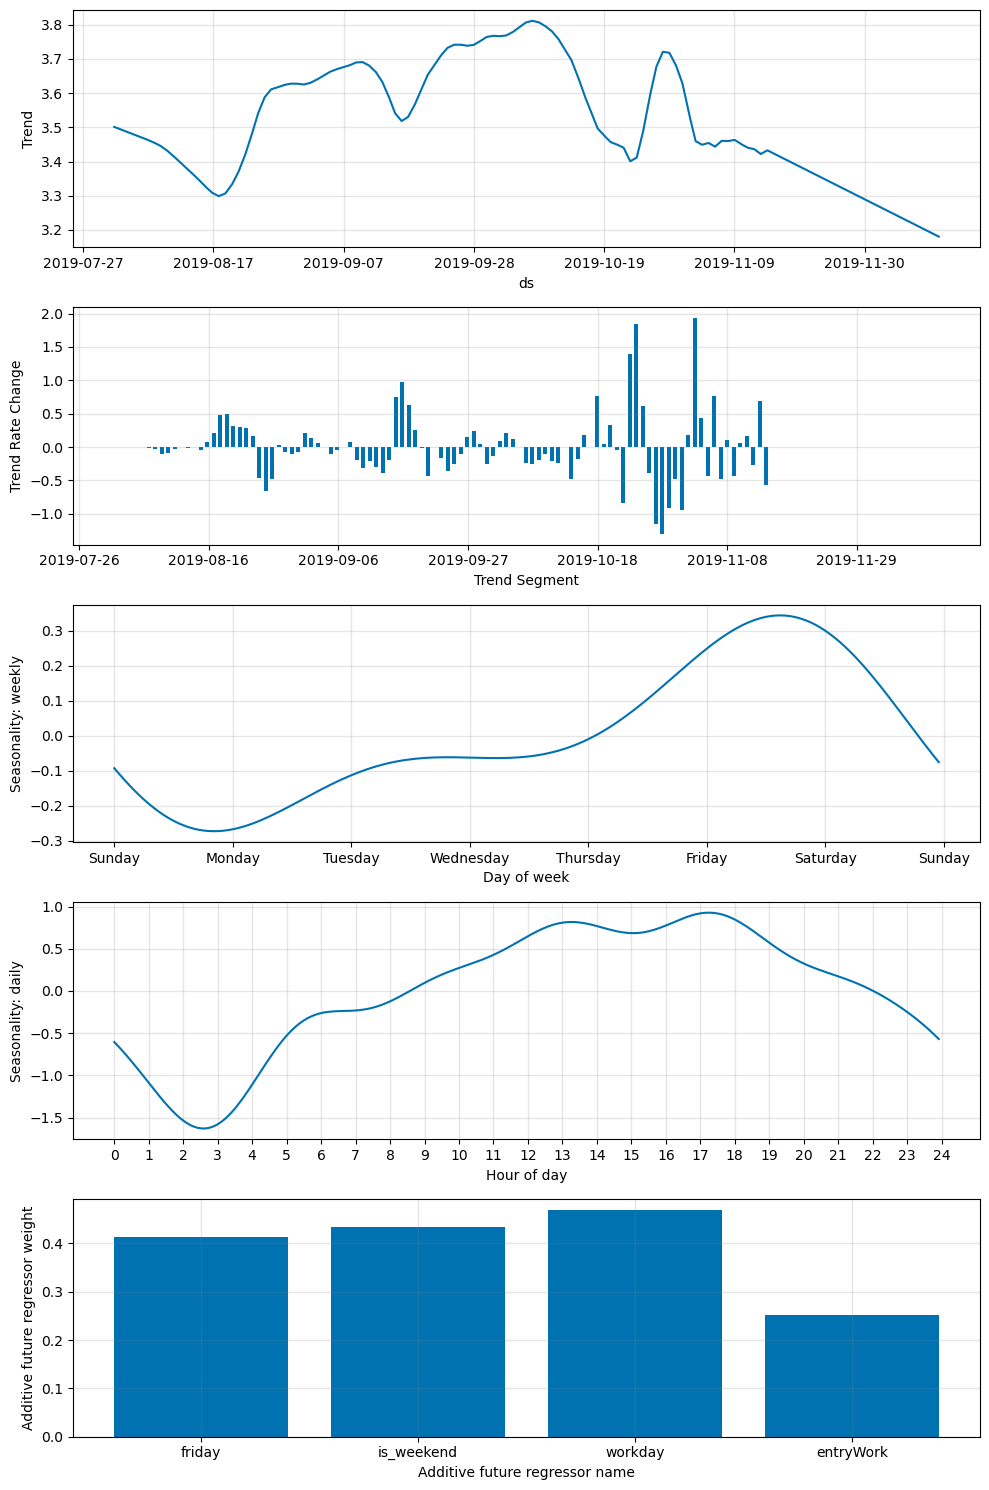

In [198]:
forecastNeural = mNeural.predict(train_log)
fig_forecast = mNeural.plot(forecastNeural)
fig_components = mNeural.plot_components(forecastNeural)
fig_model = mNeural.plot_parameters()

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.937% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.937% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


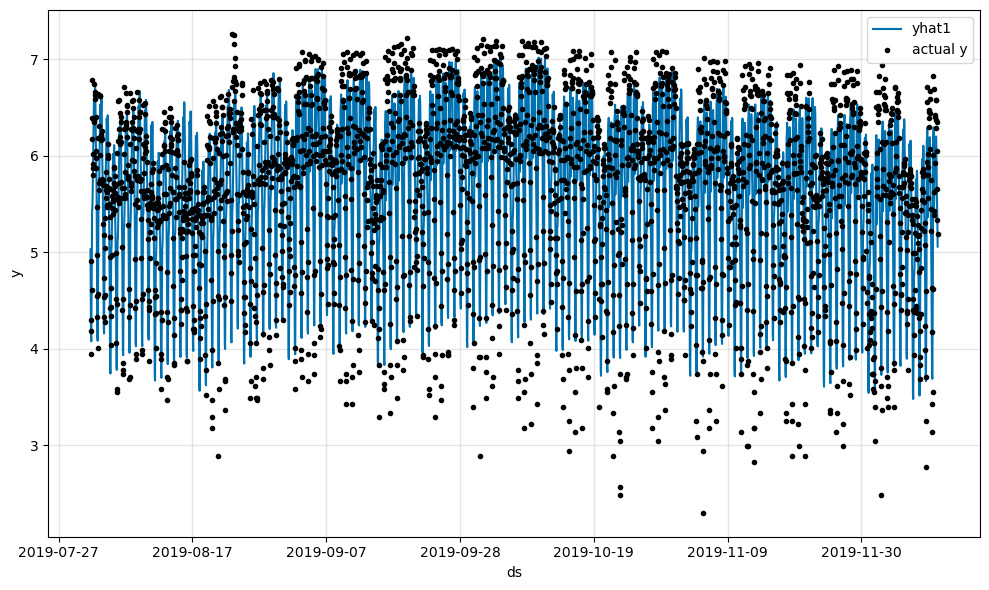

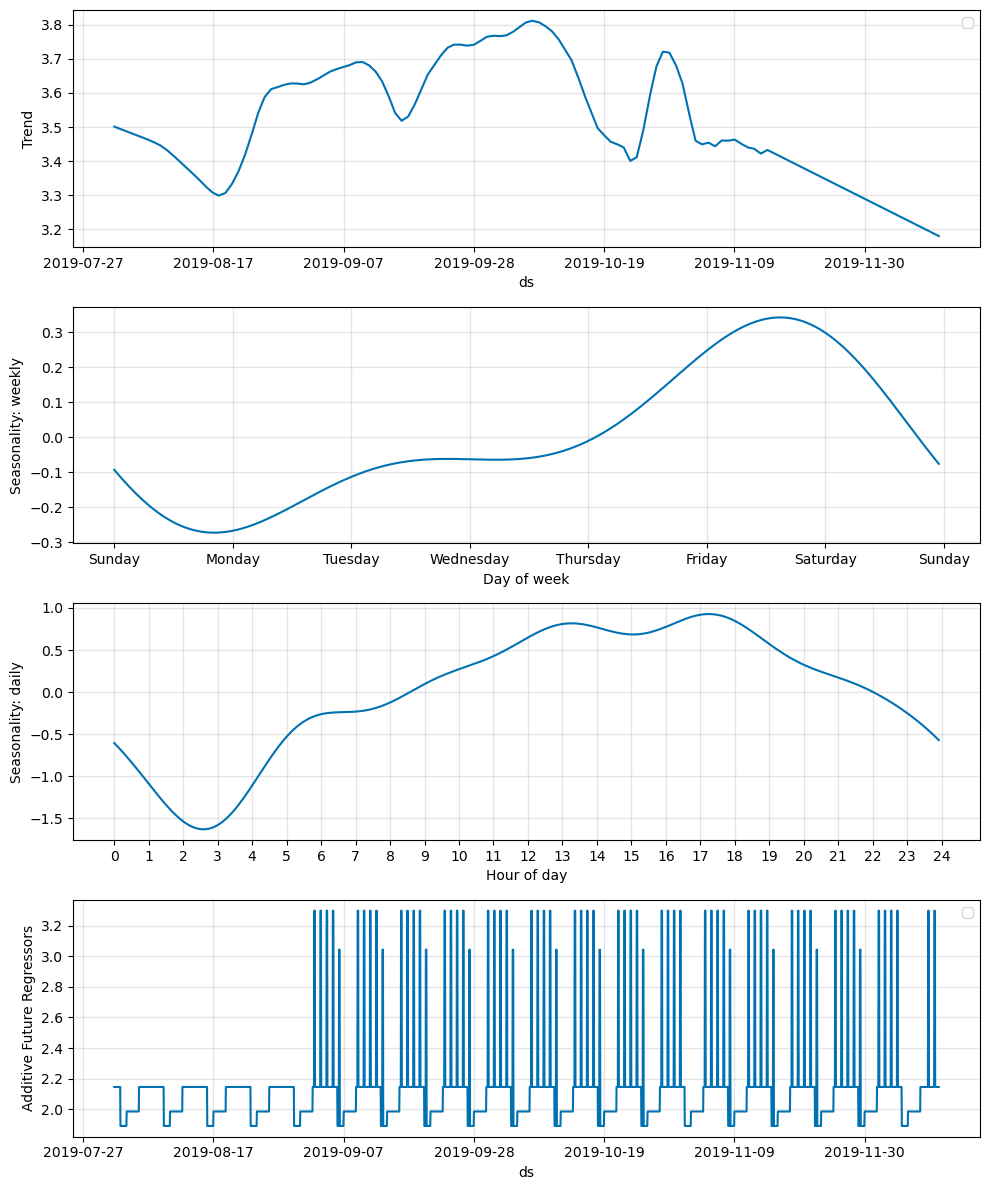

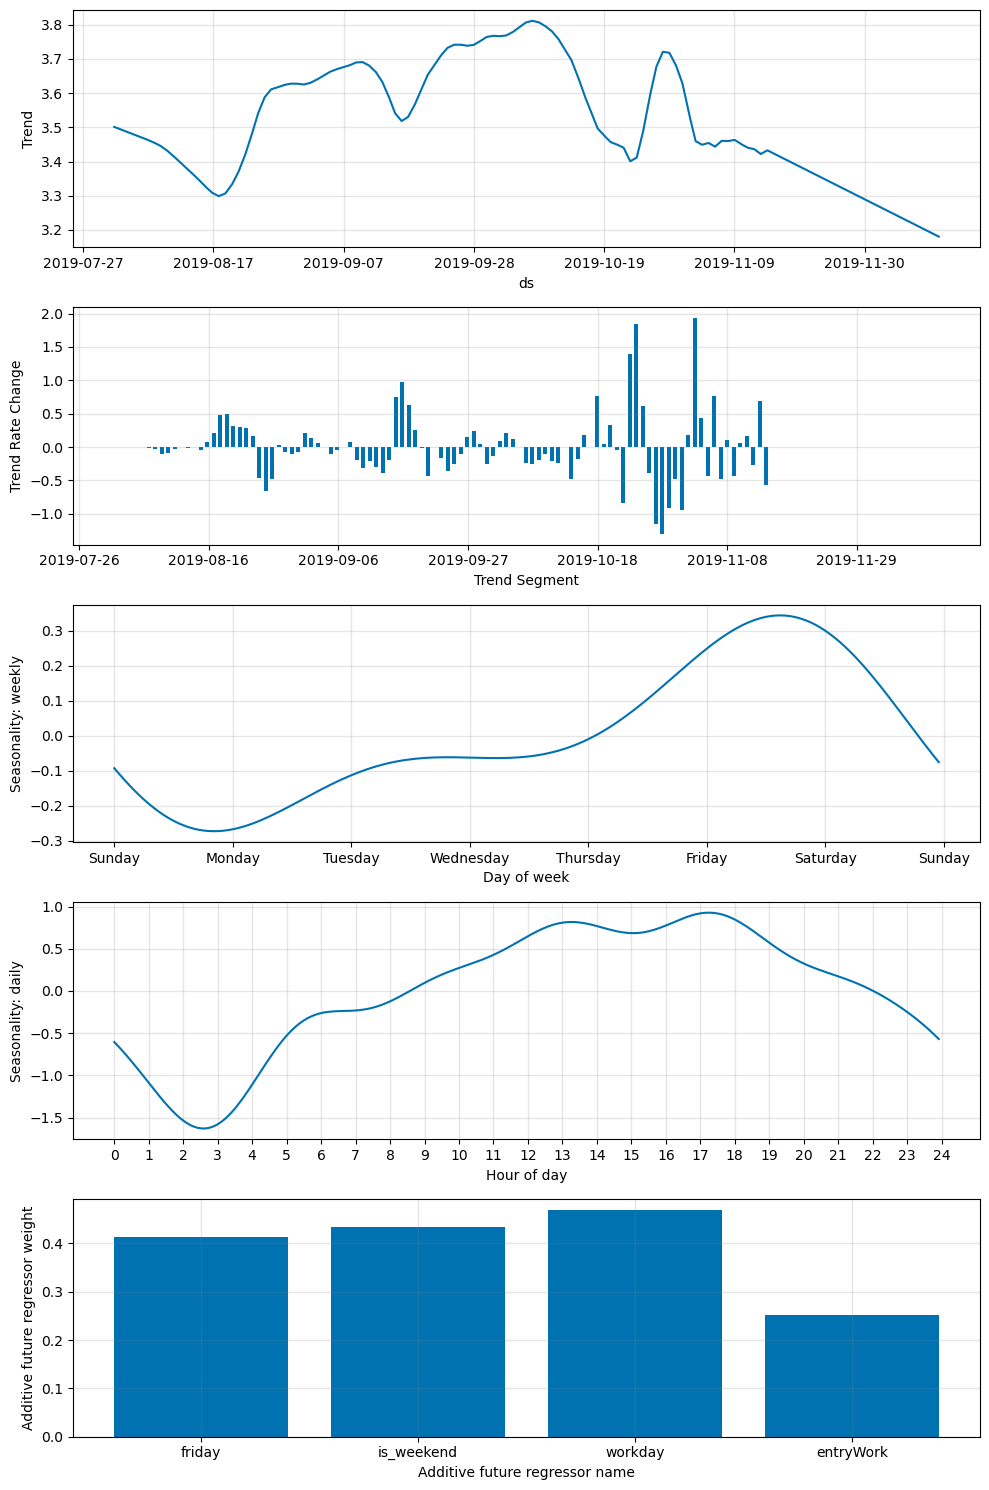

In [199]:
#futureNeural = mNeural.make_future_dataframe(train_log, periods=24*4, n_historic_predictions=len(train_log)-24*4, )
#futureNeural = mNeural.make_future_dataframe(train_log, periods=24*4)
#forecastNeural = mNeural.predict(test)
# test = itsFriday(forecast)
# test = itsWeekend(forecast)
# test = itsWorkday(forecast)
# test = entryWork(forecast,holidays)
forecastNeural = mNeural.predict(train_log)
fig_forecast = mNeural.plot(forecastNeural)
fig_components = mNeural.plot_components(forecastNeural)
fig_model = mNeural.plot_parameters()

In [200]:
forecastNeural["yhat1"] = np.exp(forecastNeural["yhat1"])
# calculate MAE between expected and predicted values for december
y_true =train['y'].iloc[-96:].values
y_pred = forecastNeural['yhat1'].iloc[-96:].values

# We convert the negative values of y_pred to 0 as demand cannot be negative
mae = mean_squared_error(y_true, y_pred)
print('MSE: %.3f' % mae)
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MSE: 15789.314
MAE: 86.602


In [201]:
data = [
    go.Scatter(
        x = train["ds"],
        y = train["y"],
        name = "Valores Reales",
        mode = "lines",
        line = dict(color = "mediumseagreen")
    ),
    go.Scatter(
        x = forecastNeural["ds"].iloc[:-96],
        y = forecastNeural["yhat1"].iloc[:-96],
        name = "Valores Predichos",
        mode = "lines",
        line = dict(color = "firebrick")
    ),
]

layout = go.Layout(title = "Forecast vs Valores reales", xaxis_title = "Fecha", yaxis_title = "Demanda")

fig = go.Figure(data = data, layout = layout)

fig.show()

In [202]:
data = [
    go.Scatter(
        x = test["ds"],
        y = test["y"],
        name = "Valores Reales",
        mode = "lines",
        line = dict(color = "mediumseagreen")
    ),
    go.Scatter(
        x = forecastNeural["ds"].iloc[-96:],
        y = forecastNeural["yhat1"].iloc[-96:],
        name = "Valores Predichos",
        mode = "lines",
        line = dict(color = "firebrick")
    ),
]

layout = go.Layout(title = "Forecast vs Valores reales", xaxis_title = "Fecha", yaxis_title = "Demanda")

fig = go.Figure(data = data, layout = layout)

fig.show()

### **Recursive autoregressive forecasting**

It is intended to create an autoregressive model capable of predicting future weekly demand of bikes.

In [58]:
# colores 
my_color1="#B5CDD3"
my_color2="#4A9B82"
my_color3 = "#C16548"
my_color4 = "#1D6295"
my_color5 = "#C8C024"

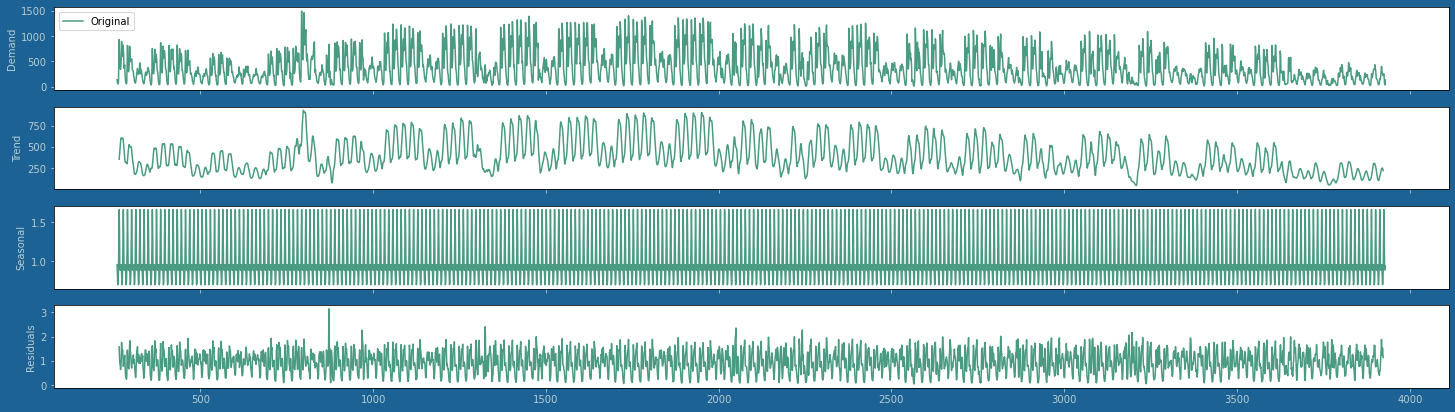

In [65]:
ts_decompose_add = seasonal_decompose(itinerarios2['y'], 
                                   model='multiplicative', 
                                   period=12) # the frequency of fluctuation is more than one year thus cyclic component
estimated_trend_add = ts_decompose_add.trend
estimated_seasonal_add = ts_decompose_add.seasonal
estimated_residual_add = ts_decompose_add.resid

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, facecolor = my_color4)
fig.set_figwidth(25)
fig.set_figheight(7)

axes[0].plot(itinerarios2['y'], label='Original', color = my_color2)
axes[0].legend(loc='upper left')
axes[0].set_ylabel('Demand', color=my_color1, size = 10)
axes[0].tick_params( colors=my_color1)

axes[1].plot(estimated_trend_add, label='Trend', color = my_color2)
axes[1].set_ylabel('Trend', color=my_color1, size = 10)
axes[1].tick_params( colors=my_color1)

axes[2].plot(estimated_seasonal_add, label='Cyclic', color = my_color2)
axes[2].set_ylabel('Seasonal', color=my_color1, size = 10)
axes[2].tick_params( colors=my_color1)

axes[3].plot(estimated_residual_add, label='Residuals', color = my_color2)
axes[3].set_ylabel('Residuals', color=my_color1, size = 10)
axes[3].tick_params( colors=my_color1)

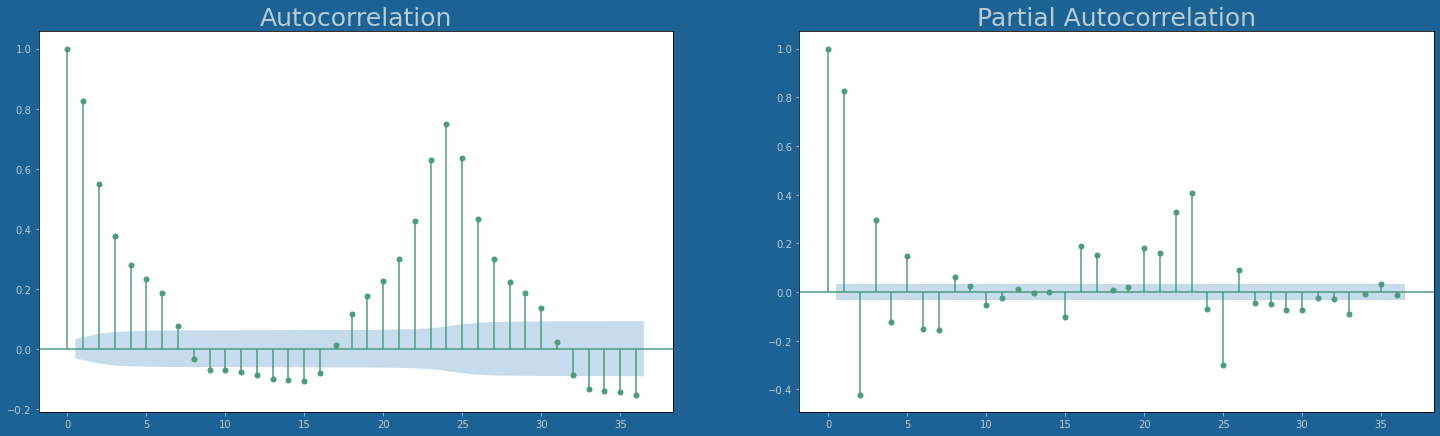

In [69]:
fig, ax = plt.subplots(1,2, facecolor = my_color4)
fig.set_figwidth(25)
fig.set_figheight(7)

plot_acf(itinerarios2['y'], ax=ax[0], color=my_color2, vlines_kwargs={"colors": my_color2})
plot_pacf(itinerarios2['y'], ax=ax[1],color=my_color2, vlines_kwargs={"colors": my_color2} )
ax[0].set_title("Autocorrelation", size=25, color = my_color1)
ax[0].tick_params( colors=my_color1)
ax[1].set_title("Partial Autocorrelation", size=25, color = my_color1)
ax[1].tick_params( colors=my_color1)
plt.rc('axes',edgecolor=my_color1)

In [74]:
itinerarios3 = itinerarios2[["ds", "y"]]
itinerarios3 = itinerarios3.set_index("ds")
itinerarios3 = itinerarios3.asfreq('H')
itinerarios3 = itinerarios3.sort_index()
itinerarios3['y'] = itinerarios3['y'].fillna(0)
itinerarios3.head()

,y
ds,
2019-08-01 00:00:00,138.0
2019-08-01 01:00:00,75.0
2019-08-01 02:00:00,66.0
2019-08-01 03:00:00,53.0
2019-08-01 04:00:00,105.0


In [75]:
(itinerarios3.index == pd.date_range(start=itinerarios3.index.min(),
                             end=itinerarios3.index.max(),
                             freq=itinerarios3.index.freq)).all()

True

Train dates : 2019-08-01 00:00:00 --- 2019-12-24 23:00:00  (n=3504)
Test dates  : 2019-12-25 00:00:00 --- 2019-12-31 23:00:00  (n=168)


Text(0, 0.5, '# Passengers (m)')

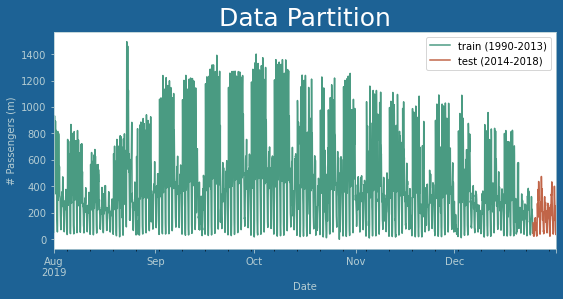

In [76]:
steps = 7*24
data_train = itinerarios3[:-steps]
data_test  = itinerarios3[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4), facecolor = my_color4)
plt.style.use('default')
data_train['y'].plot(ax=ax, label='train (1990-2013)', color = my_color2)
data_test['y'].plot(ax=ax, label='test (2014-2018)', color = my_color3)
ax.legend()
ax.set_title("Data Partition", size=25, color = "white")
ax.tick_params( colors=my_color1)
ax.set_xlabel("Date", color=my_color1)
ax.set_ylabel("# Passengers (m)", color=my_color1)

In [80]:

# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 7
             )
forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7] 
Window size: 7 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-08-01 00:00:00'), Timestamp('2019-12-24 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-11-26 15:43:13 
Last fit date: 2022-11-26 15:43:14 
Skforecast version: 0.4.3 

In [81]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2019-12-25 00:00:00    355.48
2019-12-25 01:00:00    505.77
2019-12-25 02:00:00    503.44
2019-12-25 03:00:00    355.34
2019-12-25 04:00:00    303.06
Freq: H, Name: pred, dtype: float64

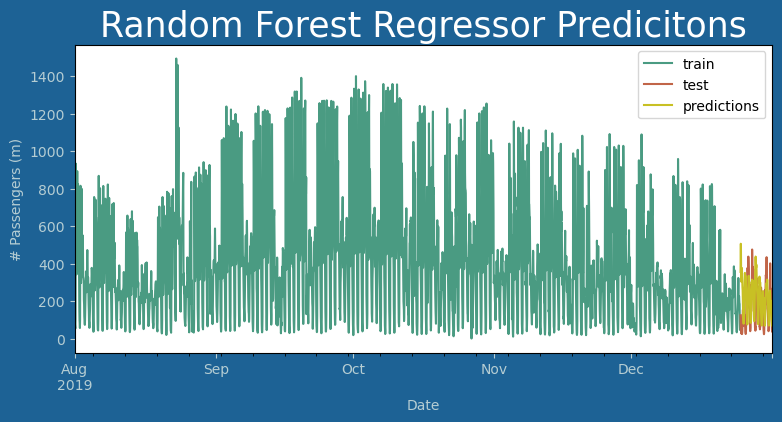

In [82]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4), facecolor = my_color4)
data_train['y'].plot(ax=ax, label='train', color=my_color2)
data_test['y'].plot(ax=ax, label='test', color=my_color3)
predictions.plot(ax=ax, label='predictions', color=my_color5)
ax.legend()
ax.set_title("Random Forest Regressor Predicitons", size=25, color = "white")
ax.tick_params( colors=my_color1)
ax.set_xlabel("Date", color=my_color1)
ax.set_ylabel("Demand", color=my_color1)
fig.savefig('RandomForestRegressorPredicitons.jpeg')

In [86]:
# Test error
# ==============================================================================
y_true = data_test['y']
y_pred = predictions
y_pred[y_pred<0] = 0

error_mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"Test error (mse): {error_mse}")
print(f"Test error (mae): {mae}")

Test error (mse): 24717.910652380953
Test error (mae): 124.57940476190477


In [150]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 24*7 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [24, 24*7]

# Regressor's hyperparameters
param_grid = {'n_estimators': [50, 70, 100, 200, 300, 400, 500],
              'max_depth': [5, 7, 8, 10, 15]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 70


loop lags_grid: 100%|███████████████████████████████████| 2/2 [4:10:06<00:00, 7503.18s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
  Parameters: {'max_depth': 15, 'n_estimators': 200}
  Backtesting metric: 28813.402323470204



In [153]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,metric,max_depth,n_estimators
66,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 15, 'n_estimators': 200}",28813.402323,15,200
65,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 15, 'n_estimators': 100}",28879.758882,15,100
69,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 15, 'n_estimators': 500}",29068.672258,15,500
68,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 15, 'n_estimators': 400}",29075.042205,15,400
67,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 15, 'n_estimators': 300}",29163.837815,15,300
...,...,...,...,...,...
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",113820.333830,5,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 200}",114819.714837,5,200
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 400}",114973.578271,5,400
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 300}",115814.911146,5,300


In [154]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=15, n_estimators=200, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 7*24
             )

forecaster.fit(y=data_train['y'])

In [161]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)
predictions.head()

2019-12-25 00:00:00    97.102463
2019-12-25 01:00:00    91.099273
2019-12-25 02:00:00    61.702168
2019-12-25 03:00:00    33.957274
2019-12-25 04:00:00    40.677444
Freq: H, Name: pred, dtype: float64

Text(0, 0.5, 'Demand')

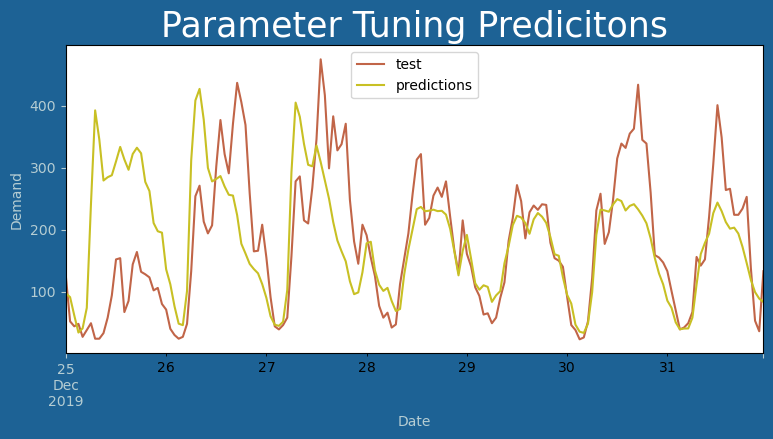

In [162]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4), facecolor = my_color4)
#data_train['y'].plot(ax=ax, label='train', color=my_color2)
data_test['y'].plot(ax=ax, label='test', color=my_color3)
predictions.plot(ax=ax, label='predictions', color=my_color5)
ax.legend()
ax.set_title("Parameter Tuning Predicitons", size=25, color = "white")
ax.tick_params( colors=my_color1)
ax.set_xlabel("Date", color=my_color1)
ax.set_ylabel("Demand", color=my_color1)

In [163]:
# Test error
# ==============================================================================
y_true = data_test['y']
y_pred = predictions
y_pred[y_pred<0] = 0

error_mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"Test error (mse): {error_mse}")
print(f"Test error (mae): {mae}")

Test error (mse): 9868.521565970033
Test error (mae): 70.91873409729412


- Lag = 24*7
- Max depth = 15
- n_estimators = 200
- MAE = 70.91

- Lag = 24*7
- Max depth = 15
- n_estimators = 100
- MAE = 70.95